<a href="https://colab.research.google.com/github/LabdhiSheth/Deep-Learning-lab-work/blob/main/18BCE101_DL_PRAC10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 18BCE101 Labdhi Sheth
Deep Learning practical - 10

Aim:
Image captioning

Importing necessary libraries

In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

from google.colab import files
!pip install -q kaggle
uploaded = files.upload()
import os
os.environ['KAGGLE_CONFIG_DIR'] ='/content/'

Saving kaggle.json to kaggle.json


Taking the dataset

In [ ]:
!kaggle datasets download -d sayanf/flickr8k

100% 1.04G/1.04G [00:21<00:00, 60.0MB/s]
100% 1.04G/1.04G [00:21<00:00, 51.7MB/s]


In [ ]:
! unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Flickr8k_Dataset/2846843520_b0e6211478.jpg  
  inflating: Flickr8k_Dataset/2847514745_9a35493023.jpg  
  inflating: Flickr8k_Dataset/2847615962_c330bded6e.jpg  
  inflating: Flickr8k_Dataset/2847859796_4d9cb0d31f.jpg  
  inflating: Flickr8k_Dataset/2848266893_9693c66275.jpg  
  inflating: Flickr8k_Dataset/2848571082_26454cb981.jpg  
  inflating: Flickr8k_Dataset/2848895544_6d06210e9d.jpg  
  inflating: Flickr8k_Dataset/2848977044_446a31d86e.jpg  
  inflating: Flickr8k_Dataset/2849194983_2968c72832.jpg  
  inflating: Flickr8k_Dataset/2850719435_221f15e951.jpg  
  inflating: Flickr8k_Dataset/2851198725_37b6027625.jpg  
  inflating: Flickr8k_Dataset/2851304910_b5721199bc.jpg  
  inflating: Flickr8k_Dataset/2851931813_eaf8ed7be3.jpg  
  inflating: Flickr8k_Dataset/2852982055_8112d0964f.jpg  
  inflating: Flickr8k_Dataset/285306009_f6ddabe687.jpg  
  inflating: Flickr8k_Dataset/2853205396_4fbe8d7a73.jpg  
  inflating: Flickr8k_

In [ ]:
! kaggle datasets download -d incorpes/glove6b200d

 99% 255M/259M [00:08<00:00, 45.8MB/s]
100% 259M/259M [00:09<00:00, 29.7MB/s]


In [ ]:
! unzip glove6b200d.zip

Archive:  glove6b200d.zip
  inflating: glove.6B.200d.txt       


In [ ]:
token_path = "/content/Flickr8k_text/Flickr8k.token.txt"
train_images_path = '/content/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/content/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '/content/Flickr8k_Dataset/'
glove_path = '/content/'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [ ]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [ ]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

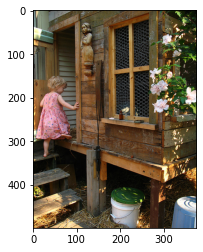

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [ ]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [ ]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [ ]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [ ]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [ ]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [ ]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

Defining the model

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 [==============================] - 280s 140ms/step - loss: 2.6385
Epoch 2/30
2000/2000 [==============================] - 278s 139ms/step - loss: 2.5531
Epoch 3/30
2000/2000 [==============================] - 275s 137ms/step - loss: 2.5007
Epoch 4/30
2000/2000 [==============================] - 279s 139ms/step - loss: 2.4596
Epoch 5/30
2000/2000 [==============================] - 277s 139ms/step - loss: 2.4242
Epoch 6/30
2000/2000 [==============================] - 276s 138ms/step - loss: 2.3939
Epoch 7/30
2000/2000 [==============================] - 277s 138ms/step - loss: 2.3692
Epoch 8/30
2000/2000 [==============================] - 274s 137ms/step - loss: 2.3469
Epoch 9/30
2000/2000 [==============================] - 274s 137ms/step - loss: 2.3259
Epoch 10/30
2000/2000 [==============================] - 274s 137ms/step - loss: 2.3066
Epoch 11/30
2000/2000 [==============================] - 272s 136ms/step - loss: 2.2916
Epoch 12/30
2000/2000 [==================

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

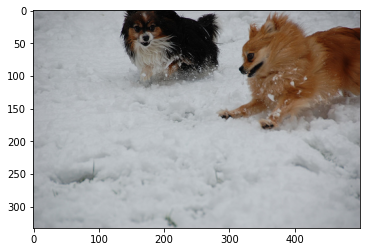

Greedy Search: a dog runs through the grass
Beam Search, K = 3: a white dog runs through the grass
Beam Search, K = 5: a white dog runs through the grass
Beam Search, K = 7: a white dog and a brown dog are biting each other in the snow
Beam Search, K = 10: a white dog and a brown dog are biting each other in the snow


In [ ]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

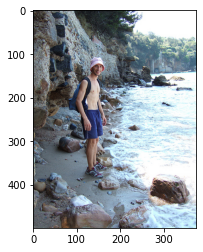

Greedy: a woman in a bikini is sitting on a rock next to a creek
Beam Search, K = 3: a woman is sitting on the edge of a rocky cliff overlooking the water
Beam Search, K = 5: a woman is sitting on the edge of a rock next to a lake
Beam Search, K = 7: a group of people sit on the rocks overlooking the ocean


In [ ]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

# Conclusion
Program uses using an Encoder-Decoder model. Encoder model will combine both the encoded form of the image and the encoded form of the text caption and feed to the decoder.
Model will treat CNN as the ‘image model’ and the RNN/LSTM as the ‘language model’ to encode the text sequences of varying length. The vectors resulting from both the encodings are then merged and processed by a Dense layer to make a final prediction.